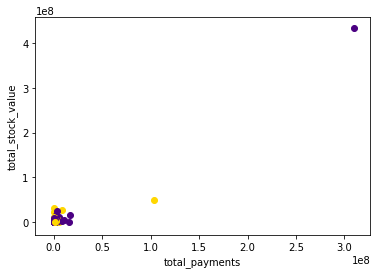

None


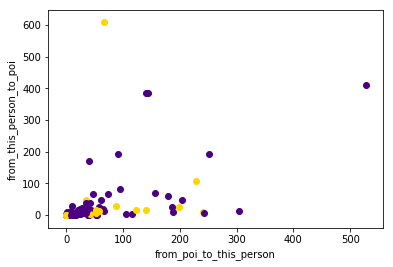

None


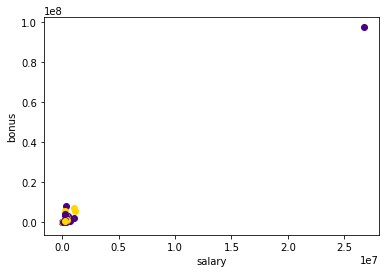

None


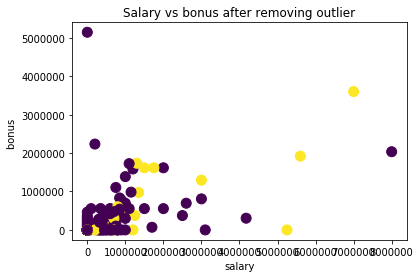

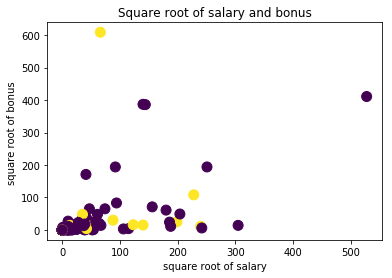

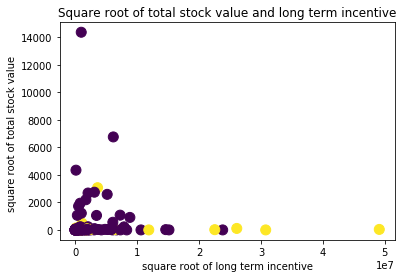

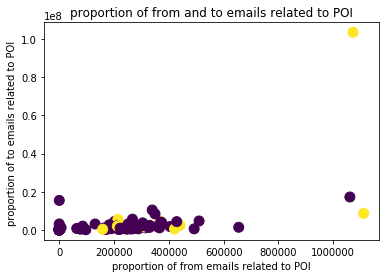

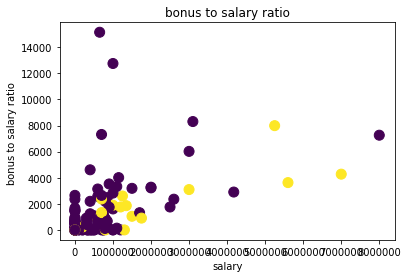

[ Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False))])

Processing....................................................................................................done.

precision: 0.352495718171
recall:    0.287665581641]


[ KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.001, verbose=0)

Processing....................................................................................................done.

precision: 0.22537059921
recall:    0.383579617605]


[ RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
    

In [13]:
import sys
import pickle
import numpy as np
import pandas as pd
sys.path.append("../tools/")
import math
import matplotlib.pyplot as plt
from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from sklearn.cross_validation import StratifiedShuffleSplit
from numpy import mean
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import cross_validation 
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier




### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

target_label = 'poi'

email_features_list = [
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'to_messages',
    ]
financial_features_list = [
    'bonus',
    'long_term_incentive',
    'salary',
    'total_payments',
    'total_stock_value',
]

features_list = [target_label] + financial_features_list + email_features_list


### Load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "rb") )



### Task 2: Remove outliers

def PlotOutlier(data_dict, x, y):
    
    data = featureFormat(data_dict, [x, y, 'poi'])
    for point in data:
        xVal = point[0]
        yVal = point[1]
        poi = point[2]
        if poi:
            color = 'gold'
        else:
            color = 'indigo'
        plt.scatter(xVal, yVal, color=color)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

# Plot outliers
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(PlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))
print(PlotOutlier(data_dict, 'salary', 'bonus'))

#Remove outlier TOTAL line in pickle file.
data_dict.pop( 'TOTAL', 0 )


def remove_outlier(dict_object, keys):
    for key in keys:
        dict_object.pop(key, 0)

outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
remove_outlier(data_dict, outliers)



### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

# Create features fraction 
def compute_fraction(poi_messages, all_messages):   
    if poi_messages == 'NaN' or all_messages == 'NaN':
        return 0
    ratio = 1.0*poi_messages / all_messages
    return ratio

for name in my_dataset:
    data_point = my_dataset[name] 
    data_point["from_ratio"] = compute_fraction( data_point["from_poi_to_this_person"], data_point["to_messages"])
    data_point["to_ratio"] = compute_fraction(data_point["from_this_person_to_poi"], data_point["from_messages"])
    data_point["bonus_salary_ratio"] = compute_fraction(data_point['salary'], data_point['bonus'])


# Create square root of financial features
    
def compute_sqrt(key):
    if key == "NaN":
        return 0
    key = math.sqrt(math.fabs(key))
    return key

for key in my_dataset:
    data_point = my_dataset[key]
    data_point['sqrt_salary'] = compute_sqrt(data_point['salary'])
    data_point['sqrt_bonus'] = compute_sqrt(data_point['bonus'])
    data_point['sqrt_total_stock_value'] = compute_sqrt(data_point['total_stock_value'])
    data_point['sqrt_long_term_incentive'] = compute_sqrt(data_point['long_term_incentive'])
    
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# scatter plot of features 
poi = list(data[:,0])
salary = list(data[:,1])
bonus = list(data[:,2])
from_ratio = list(data[:,3])
to_ratio = list(data[:,4])
total_stock_value = list(data[:,5])
long_term_incentive = list(data[:,6])
sqrt_salary = list(data[:,7])
sqrt_bonus = list(data[:,8])
bonus_salary_ratio = list(data[:,9])

plt.scatter(salary, bonus, s=100, c=poi)
plt.title('Salary vs bonus after removing outlier')
plt.ylabel('bonus ')
plt.xlabel('salary')
plt.show()


plt.scatter(sqrt_salary, sqrt_bonus, s=100, c=poi)
plt.title('Square root of salary and bonus')
plt.ylabel('square root of bonus ')
plt.xlabel('square root of salary')
plt.show()

plt.scatter(total_stock_value, long_term_incentive, s=100, c=poi)
plt.title('Square root of total stock value and long term incentive')
plt.ylabel('square root of total stock value ')
plt.xlabel('square root of long term incentive')
plt.show()

plt.scatter(from_ratio, to_ratio, s=100, c=poi) 
plt.title('proportion of from and to emails related to POI')
plt.ylabel('proportion of to emails related to POI ')
plt.xlabel('proportion of from emails related to POI')
plt.show()

plt.scatter(salary, bonus_salary_ratio, s=100, c=poi)
plt.title('bonus to salary ratio')
plt.ylabel('bonus to salary ratio ')
plt.xlabel('salary')
plt.show()


features_list = ['poi','from_ratio','to_ratio',
                 'sqrt_total_stock_value','sqrt_long_term_incentive',
                 'sqrt_salary','sqrt_bonus','bonus_salary_ratio']

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html


scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

### Logistic Regression Classifier

l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(tol = 0.001, C = 10**-8, penalty = 'l2', random_state = 42))])

### K-means Clustering

k_clf = KMeans(n_clusters=2, tol=0.001)


### Random Forest

rf_clf = RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42)


### evaluate function
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3):
    print "[" , clf
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print "done.\n"
    print "precision: {}".format(mean(precision))
    print "recall:    {}]\n\n".format(mean(recall))
    return mean(precision), mean(recall)


### Evaluate all functions
evaluate_clf(l_clf, features, labels)
evaluate_clf(k_clf, features, labels)
evaluate_clf(rf_clf, features, labels)

### Select Logistic Regression as final algorithm
clf = l_clf

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script.
### Because of the small size of the dataset, the script uses stratified
### shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
# tree

dump_classifier_and_data(clf, my_dataset, features_list)

### Dump your classifier, dataset, and features_list so 
### anyone can run/check your results.

pickle.dump(clf, open("../my_classifier.pkl", "w"))
pickle.dump(my_dataset, open("../my_dataset.pkl", "w"))
pickle.dump(features_list, open("../my_feature_list.pkl", "w"))